In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Dataset
import zipfile

z = zipfile.ZipFile('archive.zip')

z.extractall()

In [3]:
folder = 'Dataset/yes/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" + str(count) + ".jpg"
    os.rename(source, destination)
    count += 1
print("All file are rename in the dir")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'Dataset/yes/Y_10.jpg' -> 'Dataset/yes/Y_2.jpg'

In [4]:
folder = 'Dataset/no/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" + str(count) + ".jpg"
    os.rename(source, destination)
    count += 1
print("All file are rename in the dir")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'Dataset/no/Y_10.jpg' -> 'Dataset/no/Y_2.jpg'

In [5]:
# EDA(Exploratory Data Analysis)

In [5]:
listyes = os.listdir("Dataset/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("Dataset/no/")
number_files_no = len(listno)
print(number_files_no)

1500
1500


In [ ]:
# Plot

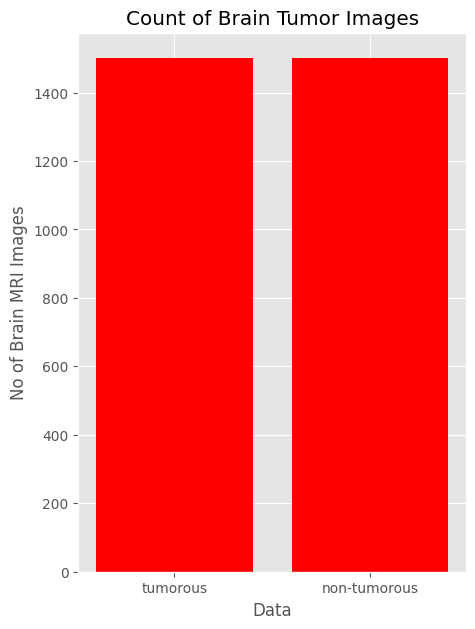

In [6]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")
plt.xlabel("Data")
plt.ylabel("No of Brain MRI Images")
plt.title("Count of Brain Tumor Images")
plt.show()

In [ ]:
# Data Augumentation

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [8]:
def timimg(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int(sec_elapsed % (60*60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [9]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                 fill_mode='nearest')
    
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape) 
        save_prefix = 'aug_' + filename[:-4]
        i = 0
        
        for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = "jpg"):
            i += 1
            if i > n_generated_samples:
                break

In [10]:
import gc

gc.collect()  # Forces garbage collection


0

In [12]:
import time
start_time = time.time()

yes_path = 'Dataset/yes'
no_path = 'Dataset/no'

augmented_data_path = 'augmented_data/'

augmented_data(file_dir = yes_path, n_generated_samples = 1, save_to_dir = augmented_data_path + 'yes')
augmented_data(file_dir = no_path, n_generated_samples = 2, save_to_dir = augmented_data_path + 'no')

end_time = time.time()
execution_time = end_time - start_time

In [13]:
def data_summary(main_path):
    yes_path = "augmented_data/yes/"
    no_path = "augmented_data/no/"

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))

    n = (n_pos + n_neg)

    pos_per = (n_pos*100)/n
    neg_per = (n_neg*100)/n

    print(f"Number of sample{n}")
    print(f"{n_pos}Number of positive sample in percentage: {pos_per}%")
    print(f"{n_neg}Number of negative sample in percentage: {neg_per}%")

In [14]:
data_summary(augmented_data_path)

Number of sample7499
3000Number of positive sample in percentage: 40.005334044539275%
4499Number of negative sample in percentage: 59.994665955460725%


In [15]:
listyes = os.listdir("augmented_data/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("augmented_data/no/")
number_files_no = len(listno)
print(number_files_no)

3000
4499


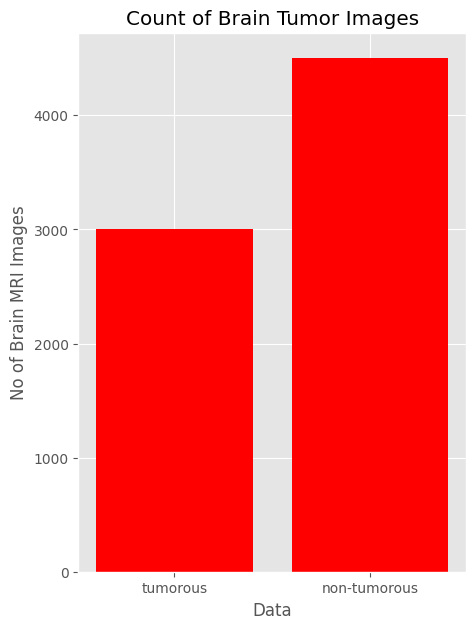

In [16]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")
plt.xlabel("Data")
plt.ylabel("No of Brain MRI Images")
plt.title("Count of Brain Tumor Images")
plt.show()

In [17]:
# Data Preprocessing

In [18]:
import imutils
def crop_brain_tumor(image, plot=False):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply GaussianBlur to reduce noise
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply thresholding
    _, thes = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)
    
    # Erode and dilate to remove noise and improve contour detection
    thes = cv2.erode(thes, None, iterations=2)
    thes = cv2.dilate(thes, None, iterations=2)

    # Find contours
    cnts = cv2.findContours(thes.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    # Check if contours exist
    if len(cnts) == 0:
        print("No contours found!")
        return image  # Return the original image if no contours are found
    
    # Find the largest contour based on area
    c = max(cnts, key=cv2.contourArea)

    # Get the extreme points of the bounding box
    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])

    # Crop the image based on the bounding box
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    # Optionally plot the images
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

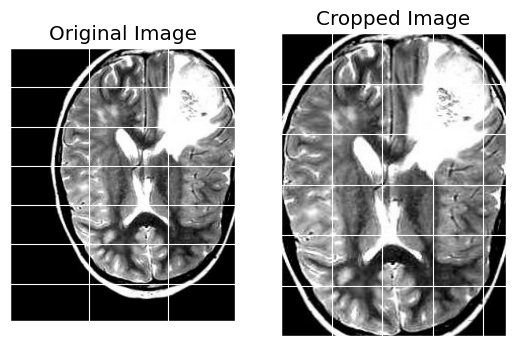

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [20]:
img = cv2.imread('augmented_data/yes/aug_Y_1_0_648.jpg')
crop_brain_tumor(img, True)

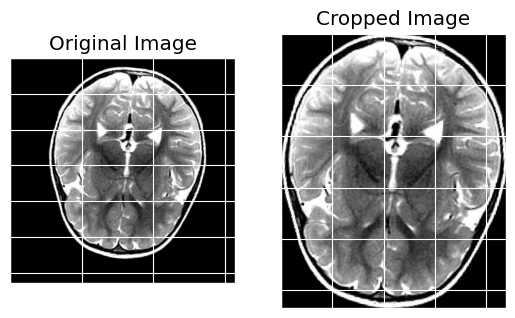

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [21]:
img = cv2.imread('augmented_data/no/aug_Y_1_0_3990.jpg')
crop_brain_tumor(img, True)

In [22]:
folder1 = 'augmented_data/no/'
folder2 = 'augmented_data/yes/'

for filename in os.listdir(folder1):
    img = cv2.imread(folder1 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder1 + filename, img)
                
for filename in os.listdir(folder2):
    img = cv2.imread(folder2 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder2 + filename, img)

In [23]:
# image loading

In [30]:
from sklearn.utils import shuffle
def load_data(dir_list, image_size):
    X=[]
    y=[]
    
    image_width, image_height=image_size
    
    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_tumor(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
            image = image/255.00
            X.append(image)
            if directory[-3:] == "yes":
                y.append(1)
            else:
                y.append(0)
    X=np.array(X)
    y=np.array(y)
    
    X,y = shuffle(X,y)
    print(f"Number of example is : {len(X)}")
    print(f"X SHAPE is : {X.shape}")
    print(f"y SHAPE is : {y.shape}")
    return X,y

In [31]:
augmented_path = 'augmented_data/'
augmented_yes = augmented_path + 'yes'
augmented_no = augmented_path + 'no'

IMAGE_WIDTH, IMAGE_HEIGHT = (240,240)

X,y = load_data([augmented_yes, augmented_no], (IMAGE_WIDTH, IMAGE_HEIGHT))

Number of example is : 7499
X SHAPE is : (7499, 240, 240, 3)
y SHAPE is : (7499,)


In [45]:
def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False,
                            labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

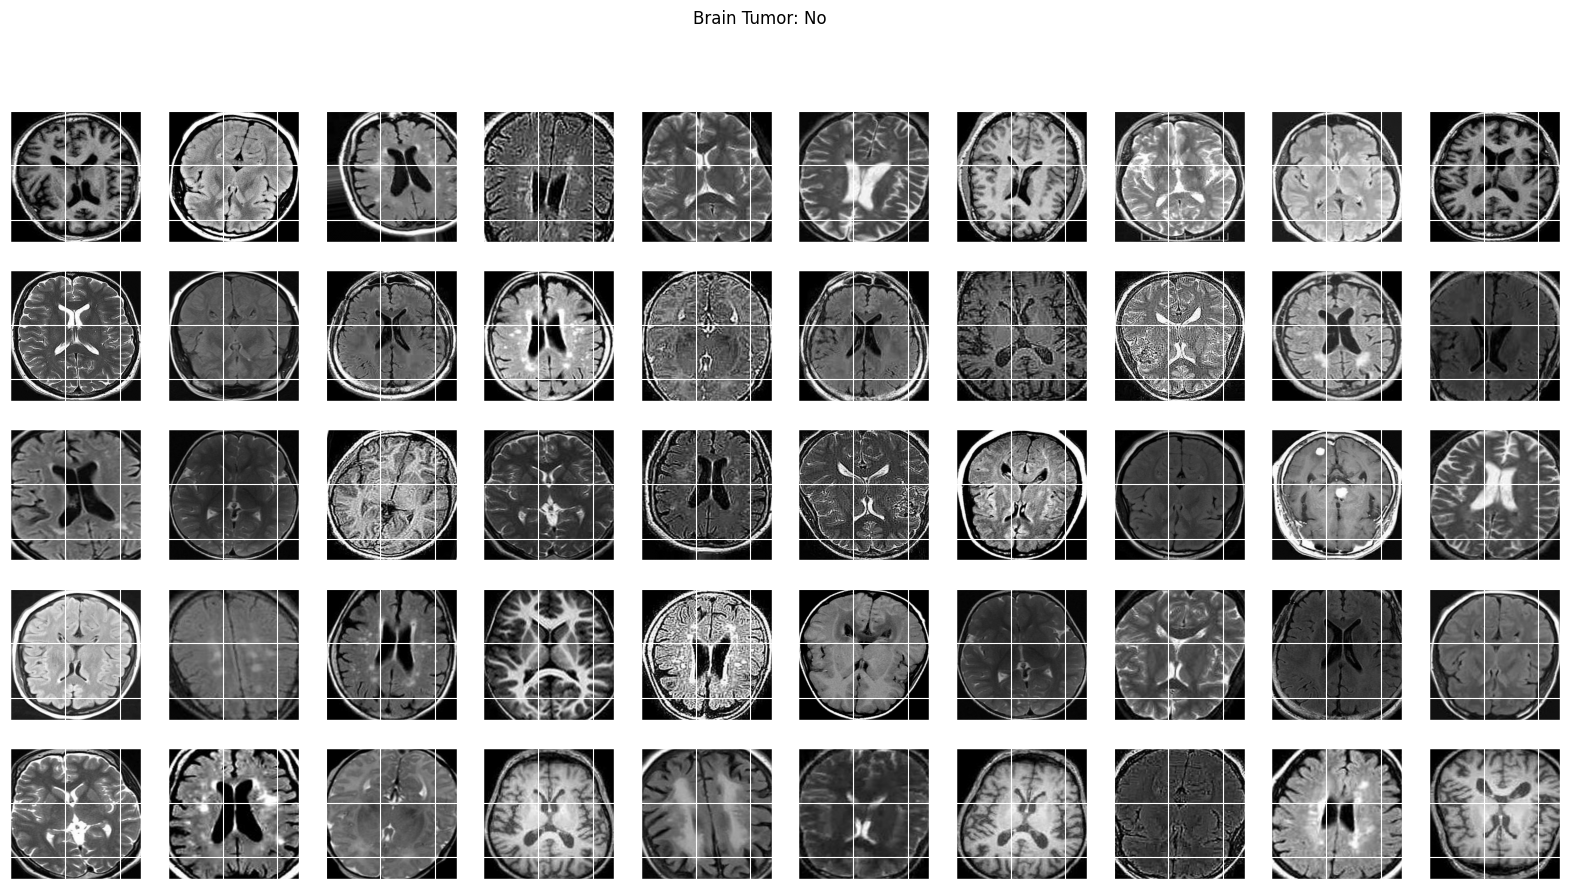

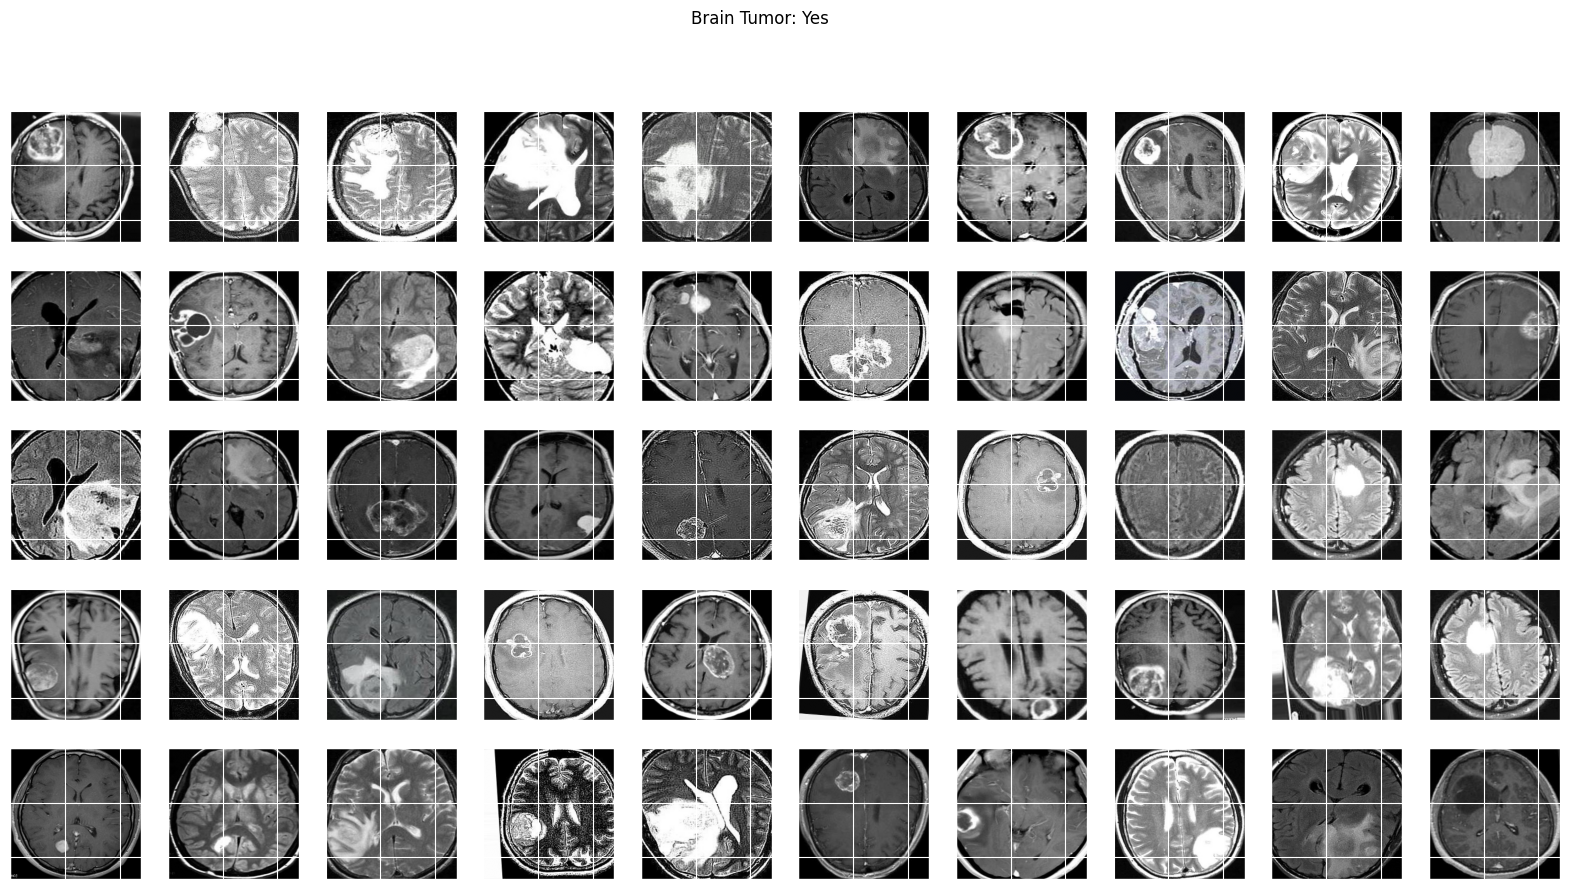

In [46]:
plot_sample_images(X,y)

In [ ]:
# Data Spliting

In [47]:
if not os.path.isdir('tumorous_and_nontumorous'):
    base_dir = 'tumorous_and_nontumorous'
    os.mkdir(base_dir)

In [48]:
if not os.path.isdir('tumorous_and_nontumorous/train'):
    train_dir = os.path.join(base_dir , 'train')
    os.mkdir(train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test'):
    test_dir = os.path.join(base_dir , 'test')
    os.mkdir(test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid'):
    valid_dir = os.path.join(base_dir , 'valid')
    os.mkdir(valid_dir)

In [49]:
if not os.path.isdir('tumorous_and_nontumorous/train/tumorous'):
    infected_train_dir = os.path.join(train_dir, 'tumorous')
    os.mkdir(infected_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/tumorous'):
    infected_test_dir = os.path.join(test_dir, 'tumorous')
    os.mkdir(infected_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/tumorous'):
    infected_valid_dir = os.path.join(valid_dir, 'tumorous')
    os.mkdir(infected_valid_dir)

In [50]:
if not os.path.isdir('tumorous_and_nontumorous/train/nontumorous'):
    healthy_train_dir = os.path.join(train_dir, 'nontumorous')
    os.mkdir(healthy_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/nontumorous'):
    healthy_test_dir = os.path.join(test_dir, 'nontumorous')
    os.mkdir(healthy_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/nontumorous'):
    healthy_valid_dir = os.path.join(valid_dir, 'nontumorous')
    os.mkdir(healthy_valid_dir)

In [51]:
original_dataset_tumorours = os.path.join('augmented_data', 'yes/')
original_dataset_nontumorours = os.path.join('augmented_data', 'no/')

In [53]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(0,2400):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_train_dir, fname)
    shutil.copyfile(src, dst)

In [54]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(2400,2700):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_test_dir, fname)
    shutil.copyfile(src, dst)

In [55]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(2700,3000):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_valid_dir, fname)
    shutil.copyfile(src, dst)

In [56]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(0,3600):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_train_dir, fname)
    shutil.copyfile(src, dst)

In [57]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(3600,4050):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src, dst)

In [58]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(4050,4499):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_valid_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
# Model Buliding

In [59]:
train_datagen = ImageDataGenerator(rescale = 1.0/255,
                   horizontal_flip = 0.4,
                   vertical_flip = 0.4,
                   rotation_range = 40,
                   shear_range = 0.2,
                   width_shift_range = 0.4,
                   height_shift_range = 0.4,
                   fill_mode = 'nearest')
test_data_gen = ImageDataGenerator(rescale = 1.0/255)
valid_data_gen = ImageDataGenerator(rescale = 1.0/255)

In [60]:
train_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/train/', batch_size = 32, target_size = (240,240), class_mode = 'categorical', shuffle=True, seed = 42, color_mode = 'rgb')


Found 6000 images belonging to 2 classes.


In [61]:
test_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/test/', batch_size = 32, target_size = (240,240), class_mode = 'categorical', shuffle=True, seed = 42, color_mode = 'rgb')


Found 750 images belonging to 2 classes.


In [62]:
valid_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/valid/', batch_size = 32, target_size = (240,240), class_mode = 'categorical', shuffle=True, seed = 42, color_mode = 'rgb')


Found 749 images belonging to 2 classes.


In [63]:
class_labels = train_generator.class_indices
class_name = {value: key for (key,value) in class_labels.items()}

In [64]:
class_name

{0: 'nontumorous', 1: 'tumorous'}

In [69]:
base_model = VGG19(input_shape = (240,240,3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.input, output)
model_01.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0   

In [70]:
# callback
filepath = 'model.h5'
es = EarlyStopping(monitor = 'val_loss', verbose = 1, mode = 'min', patience = 4)
cp = ModelCheckpoint(filepath, monitor = 'val_loss', verbose = 1, save_best_only = True, save_weight_only = False, mode = 'auto', save_freg = 'epoch')
lrr = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.001)

In [71]:
sgd = SGD(learning_rate=0.0001, weight_decay=1e-6, momentum=0.9, nesterov=True)
model_01.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [80]:
history_01 = model_01.fit(train_generator, steps_per_epoch=10, epochs = 5, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/5
10/10 [==============================] - ETA: 0s - loss: 0.7209 - accuracy: 0.5250
Epoch 1: val_loss improved from 0.67579 to 0.65808, saving model to model.h5


C:\Users\lettuce\.conda\envs\Intel\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 105s 11s/step - loss: 0.7209 - accuracy: 0.5250 - val_loss: 0.6581 - val_accuracy: 0.6142 - lr: 1.0000e-04
Epoch 2/5
10/10 [==============================] - ETA: 0s - loss: 0.6636 - accuracy: 0.6000
Epoch 2: val_loss improved from 0.65808 to 0.64417, saving model to model.h5
10/10 [==============================] - 108s 12s/step - loss: 0.6636 - accuracy: 0.6000 - val_loss: 0.6442 - val_accuracy: 0.6395 - lr: 1.0000e-04
Epoch 3/5
10/10 [==============================] - ETA: 0s - loss: 0.6420 - accuracy: 0.6375
Epoch 3: val_loss did not improve from 0.64417
10/10 [==============================] - 102s 11s/step - loss: 0.6420 - accuracy: 0.6375 - val_loss: 0.6509 - val_accuracy: 0.6182 - lr: 1.0000e-04
Epoch 4/5
10/10 [==============================] - ETA: 0s - loss: 0.6219 - accuracy: 0.6625
Epoch 4: val_loss improved from 0.64417 to 0.63817, saving model to model.h5
10/10 [==============================] - 103s 11s/step - loss: 0.6219 - accu

In [81]:
print(history_01.history)

{'loss': [0.7208660840988159, 0.6636127829551697, 0.6420078873634338, 0.6219128370285034, 0.6238320469856262], 'accuracy': [0.5249999761581421, 0.6000000238418579, 0.637499988079071, 0.6625000238418579, 0.6656249761581421], 'val_loss': [0.6580754518508911, 0.6441721320152283, 0.6508936285972595, 0.6381694674491882, 0.6664470434188843], 'val_accuracy': [0.614152193069458, 0.6395193338394165, 0.6181575655937195, 0.6301735639572144, 0.614152193069458], 'lr': [1e-04, 1e-04, 1e-04, 1e-04, 1e-04]}


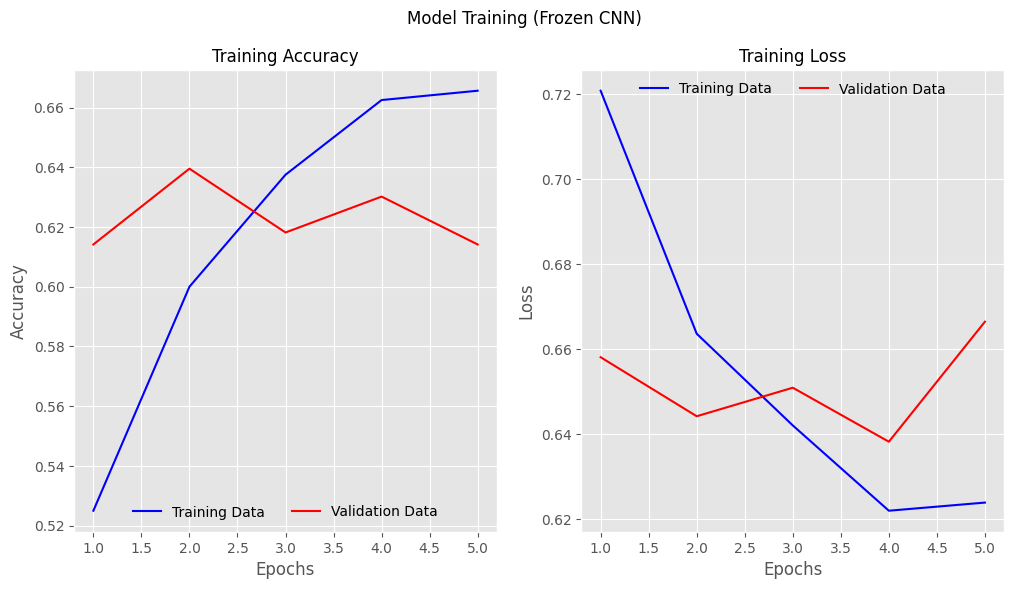

In [82]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [83]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_01.save_weights(filepath = "model_weights/vgg19_model_01.h5", overwrite = True)

In [84]:
model_01.load_weights("model_weights/vgg19_model_01.h5")
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

24/24 [==============================] - 70s 3s/step - loss: 0.6611 - accuracy: 0.6147


In [87]:
print(f'Validation Loss: {vgg_val_eval_01[0]}')
print(f'Validation Acc: {vgg_val_eval_01[1]}')
print(f'Validation Loss: {vgg_test_eval_01[0]}')
print(f'Validation Acc: {vgg_test_eval_01[1]}')

Validation Loss: 0.6642393469810486
Validation Acc: 0.6154873371124268
Validation Loss: 0.6610862612724304
Validation Acc: 0.6146666407585144


In [88]:
filenames = test_generator.filenames
nb_sample = len(filenames)

vgg_prediction_01 = model_01.predict(test_generator, steps = nb_sample, verbose = 1)
y_pred = np.argmax(vgg_prediction_01, axis = 1)

750/750 [==============================] - 70s 89ms/step


In [ ]:
# Increamental unfreezing and fine tuning

In [90]:
base_model = VGG19(include_top = False, input_shape = (240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

['input_4',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [91]:
base_model = VGG19(include_top = False, input_shape = (240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('model_weights/vgg19_model_01.h5')

set_trainable = False
for layer in base_model.layers:
    if layer.name in ['block5_conv4', 'block5_conv3']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print(model_02.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0   

In [93]:
sgd = SGD(learning_rate=0.0001, weight_decay=1e-6, momentum=0.9, nesterov=True)
model_02.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [94]:
history_02 = model_02.fit(train_generator, steps_per_epoch=10, epochs = 5, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/5
10/10 [==============================] - ETA: 0s - loss: 0.6552 - accuracy: 0.6125
Epoch 1: val_loss improved from 0.63817 to 0.62983, saving model to model.h5


C:\Users\lettuce\.conda\envs\Intel\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 117s 12s/step - loss: 0.6552 - accuracy: 0.6125 - val_loss: 0.6298 - val_accuracy: 0.6475 - lr: 1.0000e-04
Epoch 2/5
10/10 [==============================] - ETA: 0s - loss: 0.6240 - accuracy: 0.6531
Epoch 2: val_loss improved from 0.62983 to 0.62182, saving model to model.h5
10/10 [==============================] - 118s 13s/step - loss: 0.6240 - accuracy: 0.6531 - val_loss: 0.6218 - val_accuracy: 0.6489 - lr: 1.0000e-04
Epoch 3/5
10/10 [==============================] - ETA: 0s - loss: 0.6062 - accuracy: 0.6562
Epoch 3: val_loss improved from 0.62182 to 0.60644, saving model to model.h5
10/10 [==============================] - 119s 13s/step - loss: 0.6062 - accuracy: 0.6562 - val_loss: 0.6064 - val_accuracy: 0.6689 - lr: 1.0000e-04
Epoch 4/5
10/10 [==============================] - ETA: 0s - loss: 0.6387 - accuracy: 0.6656
Epoch 4: val_loss improved from 0.60644 to 0.58838, saving model to model.h5
10/10 [==============================] - 122s 

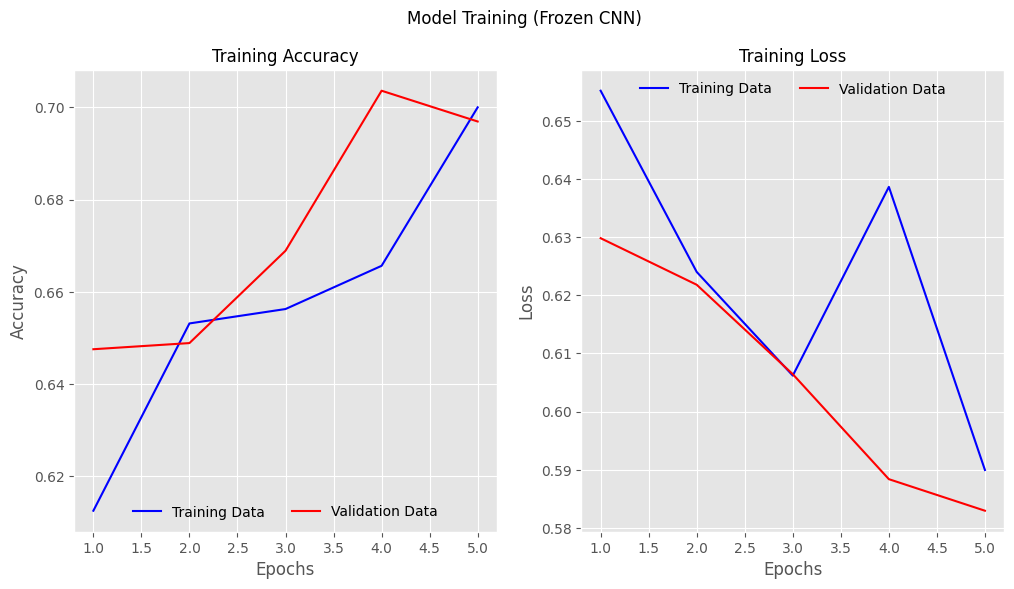

In [95]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_02.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_02.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_02.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_02.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [96]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_02.save_weights(filepath = "model_weights/vgg19_model_02.h5", overwrite = True)

In [97]:
model_02.load_weights("model_weights/vgg19_model_02.h5")
vgg_val_eval_02 = model_01.evaluate(valid_generator)
vgg_test_eval_02 = model_01.evaluate(test_generator)

24/24 [==============================] - 72s 3s/step - loss: 0.6704 - accuracy: 0.6227


In [98]:
# Unfreezing the entire network

In [100]:
base_model = VGG19(include_top = False, input_shape = (240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_03 = Model(base_model.inputs, output)
model_03.load_weights('model_weights/vgg19_model_02.h5')

sgd = SGD(learning_rate=0.0001, weight_decay=1e-6, momentum=0.9, nesterov=True)
model_03.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


In [101]:
model_03.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0   

In [105]:
history_03 = model_03.fit(train_generator, steps_per_epoch=10, epochs = 2, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/2
10/10 [==============================] - ETA: 0s - loss: 0.6147 - accuracy: 0.6594 
Epoch 1: val_loss did not improve from 0.58296
10/10 [==============================] - 210s 22s/step - loss: 0.6147 - accuracy: 0.6594 - val_loss: 0.5949 - val_accuracy: 0.6876 - lr: 1.0000e-04
Epoch 2/2
10/10 [==============================] - ETA: 0s - loss: 0.6279 - accuracy: 0.6500 
Epoch 2: val_loss improved from 0.58296 to 0.56684, saving model to model.h5


C:\Users\lettuce\.conda\envs\Intel\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 202s 21s/step - loss: 0.6279 - accuracy: 0.6500 - val_loss: 0.5668 - val_accuracy: 0.7276 - lr: 1.0000e-04


In [107]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_03.save_weights(filepath = "model_weights/vgg19_unfrozen.h5", overwrite = True)

In [108]:
model_03.load_weights("model_weights/vgg19_unfrozen.h5")
vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

24/24 [==============================] - 72s 3s/step - loss: 0.5895 - accuracy: 0.6987
